        data  native_data             op        size
0      0.859          0.0           read    0.003906
1      0.718          0.0           read    0.003906
2      0.662          0.0           read    0.003906
3      0.607          0.0           read    0.003906
4      1.191          0.0           read    0.003906
...      ...          ...            ...         ...
17012  1.158          0.0           read  256.000000
17013  1.256          0.0           read  256.000000
17014  1.419          0.0           read  256.000000
17015  1.213          0.0           read  256.000000
17016  0.000          NaN  read_capacity  256.000000

[17017 rows x 4 columns]


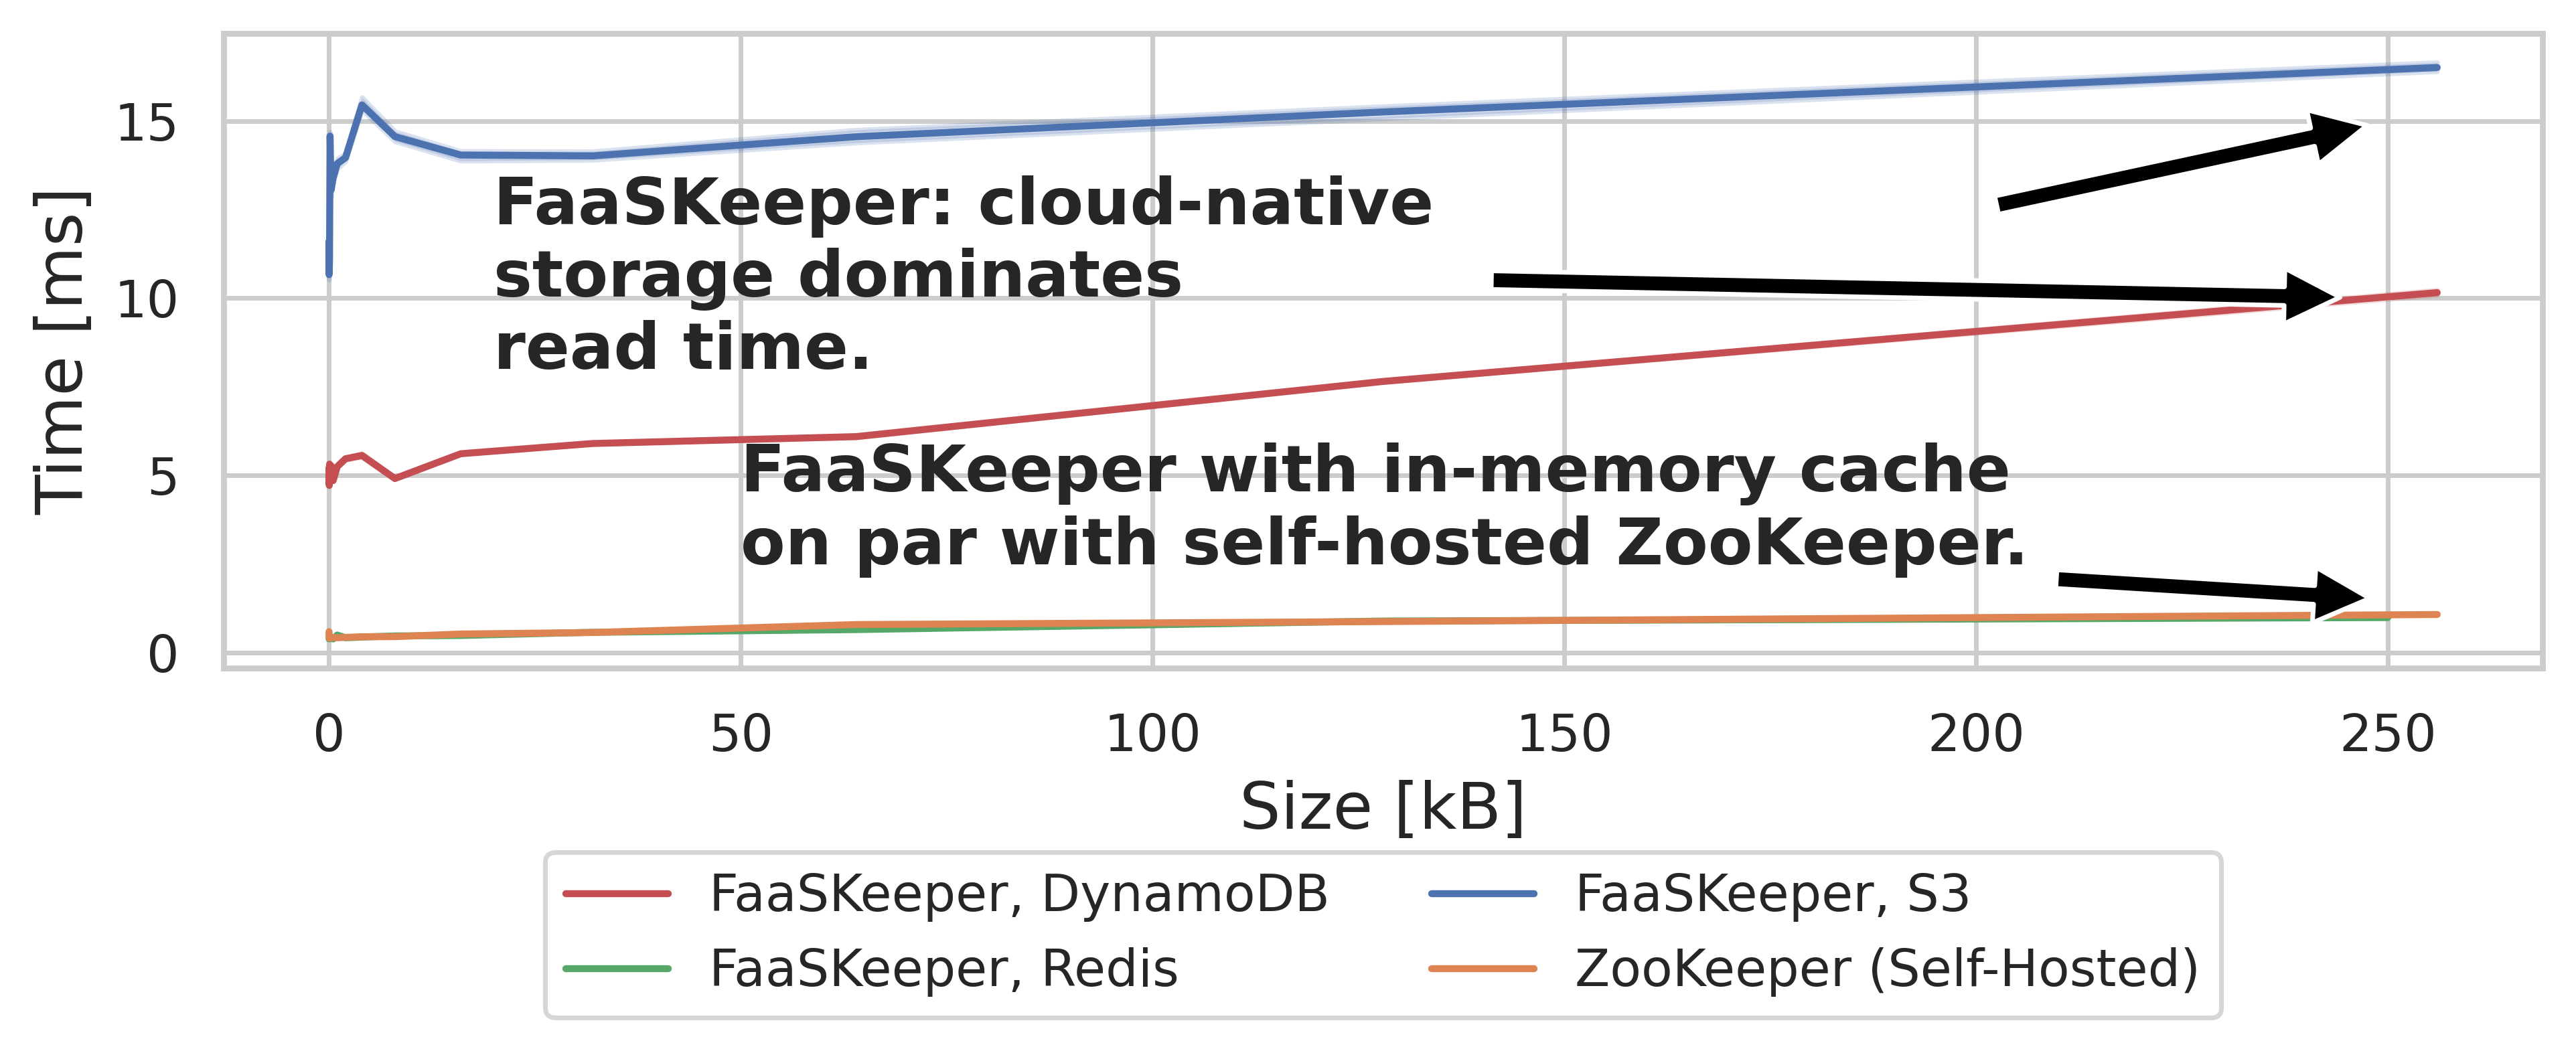

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

sns.set(rc={'figure.figsize':(8,3.5)})
sns.set_style("whitegrid")

def p50_estimator(x):                                            
    return np.percentile(x, 50)       
def p95_estimator(x):                                            
    return np.percentile(x, 95)         
       

# DynamoDB
key_value = pd.read_csv(join(DATA_DIR, 'key_value.csv'), index_col=0)
redis = pd.read_csv(join(DATA_DIR, 'redis.csv'), index_col=0)
persistent = pd.read_csv(join(DATA_DIR, 'persistent.csv'), index_col=0)
zookeeper = pd.read_csv(join(DATA_DIR, 'zookeeper', 'intrazone.csv'), index_col=0)
key_value['data'] /= 1000.0
redis['data'] /= 1000.0
persistent['data'] /= 1000.0
zookeeper['data'] /= 1000.0

key_value['size'] /= 1024.0
redis['size'] /= 1024.0
persistent['size'] /= 1024.0
zookeeper['size'] /= 1024.0

key_value = key_value.drop(key_value[key_value['size'] > 256].index)
persistent = persistent.drop(persistent[persistent['size'] > 256].index)
zookeeper = zookeeper.drop(zookeeper[zookeeper['size'] > 256].index)
print(zookeeper)

sns.lineplot(
    data=key_value.loc[key_value['op'] == 'write'], x='size', y='data', color='r',
    estimator=p50_estimator, label='FaaSKeeper, DynamoDB')#,fontsize=20)

sns.lineplot(
    data=redis.loc[redis['op'] == 'read'], x='size', y='data', color='g',
    estimator=p50_estimator, label='FaaSKeeper, Redis')#,fontsize=20)

ax = sns.lineplot(data=persistent.loc[persistent['op'] == 'read'], x='size', y='data',
                  estimator=p50_estimator, label='FaaSKeeper, S3')#,fontsize=20)

sns.lineplot(data=zookeeper.loc[zookeeper['op'] == 'read'], x='size', y='data',
             estimator=p50_estimator, label='ZooKeeper (Self-Hosted)')#,fontsize=20)


ax.set_xlabel('Size [kB]',fontsize=14)
ax.set_ylabel('Time [ms]',fontsize=14)

ax.annotate('FaaSKeeper: cloud-native\nstorage dominates\nread time.',
            xy=(250, 10), xytext=(20,8), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)
ax.annotate('',
            xy=(250, 15), xytext=(200,12.5), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)

ax.annotate('FaaSKeeper with in-memory cache\non par with self-hosted ZooKeeper.',
            xy=(250, 1.5), xytext=(50, 2.5), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)

#plt.legend(loc=5)#, bbox_to_anchor=(0,-0.5))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()

plt.savefig("performance_plot_new.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)